<a href="https://colab.research.google.com/github/cbaldassari/manifold/blob/main/manifold_step2_wass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install community
!pip install python-louvain
!pip install tsia
!pip install easydev
!pip install colormap
!pip install tomaster
!pip install ts2vg
!pip install karateclub
!pip install POT
!pip install XlsxWriter
!pip install umap-learn
!pip install trimap
!pip install pacmap

In [ ]:
%%capture
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime
from sklearn import mixture
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
from tqdm import tqdm
import xlsxwriter

import os
import sys
import seaborn as sns

import pickle

from matplotlib import gridspec
from numba import njit, prange
from pyts.image import MarkovTransitionField

import tsia.plot
import tsia.markov
import tsia.network_graph

import community
from community import community_louvain
import networkx as nx

from matplotlib.colors import to_hex

from sklearn.mixture import GaussianMixture
import numpy as np
from scipy.stats import kurtosis, skew

import csv
from colormap import rgb2hex
from tomaster import tomato

import seaborn as sns
from pickle import FALSE
import scipy

from ts2vg import NaturalVG
from ts2vg import HorizontalVG
import networkx as nxg
import uuid
from joblib import dump, load


# import libraries
import scipy.linalg as spl
import scipy.stats as sps
%matplotlib inline

# Optimal Transport library https://github.com/rflamary/POT
import ot
import ot.plot

# for interactive widgets
#from ipywidgets import interact, interactive, fixed, interact_manual

#import ipdb

from karateclub import ASNE
from karateclub import Diff2Vec
from karateclub import GraphWave
from karateclub import Role2Vec
from karateclub import NEU
from karateclub import NetLSD
import scipy
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler
import datetime
#from missingpy import MissForest

# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

# sphinx_gallery_thumbnail_number = 4

import matplotlib.pylab as plt
import ot
# necessary for 3d plot even if not used
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib.collections import PolyCollection  # noqa

import ot.lp.cvx as cvx
import umap
import random
from karateclub import FeatherGraph
from karateclub import Graph2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import trimap
import pacmap

import plotly
import plotly.express as px

In [ ]:
def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""
#find_between_r( str(model), ".", " object at" )

#Step2


In [ ]:

#log=pd.read_excel("/content/drive/MyDrive/Mari/Paper6/data/chartData/x.xlsx")

In [ ]:
ret=pd.read_excel("/content/drive/MyDrive/Mari/Paper6/data/chartData/r.xlsx")

##Descriptive table

In [ ]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming ret is your DataFrame with 14 time series
# ret = ...

descrip = pd.DataFrame()

for col in ret.columns:
    # Ensure the data is in a numeric format
    series = pd.to_numeric(ret[col], errors='coerce')

    # Calculate statistics
    descrip.loc[col, "mean"] = series.mean()
    descrip.loc[col, "std"] = series.std()
    descrip.loc[col, "skew"] = skew(series)
    descrip.loc[col, "kurtosis"] = kurtosis(series) + 3

# Now 'descrip' DataFrame contains the desired statistics for each time series


In [ ]:
descrip.to_excel("14_wass_logret_moms.xlsx")

In [ ]:
ret.drop(columns="Date", inplace=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(ret)
ret = pd.DataFrame(scaler.transform(ret), columns = ret.columns)

In [ ]:
support=[]
for (columnName, columnData) in ret.iteritems():
  support.append(columnData.min())
  support.append(columnData.max())

<ipython-input-28-ddd98a02923d>:2: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [ ]:
min(support), max(support)

(0.0, 1.0000000000000002)

In [ ]:
n = 100

x = np.arange(n, dtype=np.float64)
distout=[]

a=[]
for (columnName, columnData) in ret.iteritems():
  histogram, bins = np.histogram(columnData, bins=n, range=(min(support), max(support)), density=True)
  a.append(histogram)

A = np.vstack((a)).T
M = ot.utils.dist0(n)
M /= M.max()

ot.tic()
bary_wass2 = ot.lp.barycenter(A, M, solver='interior-point', verbose=False)
distout.append(bary_wass2)
ot.toc()

In [ ]:
cols=ret.columns
cols.shape

(14,)

In [ ]:
c=0
dik={}
for i in cols:
  dik[c]=A[:, c]
  c+=1

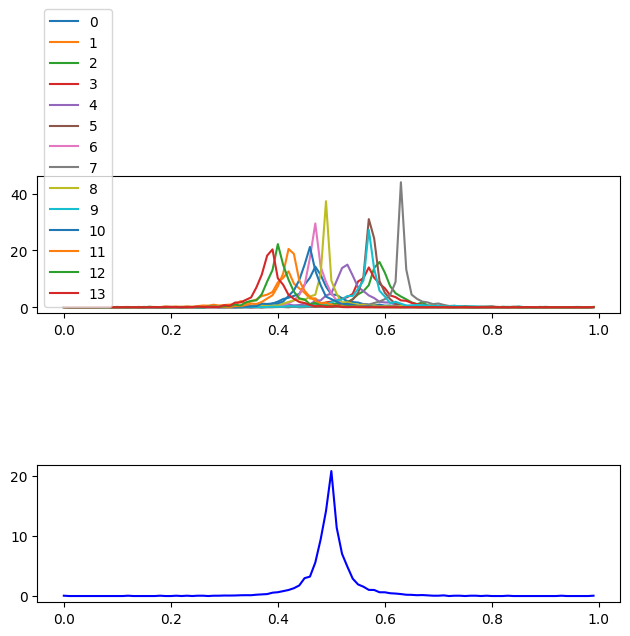

In [ ]:
plt.figure(2)
plt.clf()

plt.subplot(2, 1, 1)
for k, v in dik.items():
    plt.plot(bins[:-1], v, label=k)  # Use the label parameter to set the plot names
    #plt.title("Subplot 1")  # Set the title for subplot 1
    plt.legend()  # Add legend based on the labels

plt.subplot(2, 1, 2)
plt.plot(bins[:-1], bary_wass2, 'b')
#plt.title("Subplot 2")  # Set the title for subplot 2

plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Assuming you have bins, dik, and bary_wass2 defined

# Create line charts for each key in dik
fig = go.Figure()
for k, v in dik.items():
    fig.add_trace(go.Scatter(x=bins[:-1], y=v, mode='lines', name=k))

# Create line chart for bary_wass2
fig.add_trace(go.Scatter(x=bins[:-1], y=bary_wass2, mode='lines', name='Barycenter'))

# Set layout properties
fig.update_layout(
    xaxis_title='Bins',
    yaxis_title='Count',
    title='Line Chart with Subplots',
    height=600,
    width=800,
)

# Show the plot
fig.show()


In [ ]:
np.savetxt("/content/drive/MyDrive/Mari/Paper6/data/chartData/bary_wass2",bary_wass2)

In [ ]:
#binz=np.linspace(1, n, num=250)

In [ ]:
sequence=bins
distribution=bary_wass2

In [ ]:
tax_synth=random.choices(sequence[:-1], distribution,k=10000)
tax_synth=pd.DataFrame(tax_synth)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
tax_synth.plot()

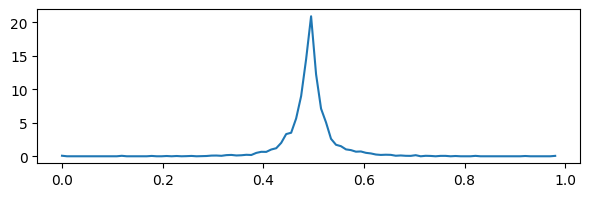

In [ ]:
histogram, bins1 = np.histogram(tax_synth, bins=n,  density=True)
plt.figure(figsize=(7,2))
plt.plot(bins1[:-1], histogram)

In [ ]:
np.savetxt("/content/drive/MyDrive/Mari/Paper6/data/chartData/tax_synth",tax_synth)

##funcs


In [ ]:
# Useful constants definition
COLORMAP = 'jet'

def get_network_graph2(mtf):
    # Build the graph with networkx:
    graph = nx.from_numpy_matrix(mtf)

    # Loops through the edges to get associate each of them with the
    # corresponding Markov transition probability:
    weights = [mtf[u,v] for u,v in graph.edges()]
    for index, e in enumerate(graph.edges()):
        graph[e[0]][e[1]]['weight'] = weights[index]

    return graph

def compute_network_graph_statistics2(partitions, graph=None, mtf=None):
    if (graph is None) and (mtf is not None):
        graph = get_network_graph(mtf)

    #partitions = community_louvain.best_partition(graph, random_state=1234)
    nb_partitions = len(set(partitions.values()))
    modularity = community_louvain.modularity(partitions, graph)


    diameter = nx.diameter(graph)
    node_size = list(nx.clustering(graph, weight='weight').values())
    avg_clustering_coeff = np.array(node_size).mean()
    density = nx.density(graph)
    avg_path_length = nx.average_shortest_path_length(graph, weight='weight', method='dijkstra')

    average_degree = nx.average_degree_connectivity(graph)
    average_degree = np.mean(list(average_degree.values()))
    avg_weighted_degree = nx.average_degree_connectivity(graph, weight='weight')
    avg_weighted_degree = np.mean(list(avg_weighted_degree.values()))

    statistics = {
        'Diameter': diameter,
        'Average degree': average_degree,
        'Average weighted degree': avg_weighted_degree,
        'Density': density,
        'Average path length': avg_path_length,
        'Average clustering coefficient': avg_clustering_coeff,
        'Modularity': modularity,
        'Partitions': nb_partitions
    }

    return statistics

def get_modularity_encoding2(graph, colormap=COLORMAP, reversed_cmap=False):

    if reversed_cmap == True:
        colormap = plt.cm.get_cmap(colormap).reversed()
    else:
        colormap = plt.cm.get_cmap(colormap)

    # Get the node partitions and number of partitions found with the Louvain
    # algorithm, as implemented in the `community` package:

    partitions = community_louvain.best_partition(graph, random_state=1234)
    #####################################

    nb_partitions = len(set(partitions.values()))
    #print("nb_partitions: ",nb_partitions)

    # Compute node colors and edges colors for the modularity encoding:
    edge_colors = [to_hex(colormap(partitions.get(v)/(nb_partitions - 1))) for u,v in graph.edges()]
    node_colors = [partitions.get(node) for node in graph.nodes()]
    node_size = list(nx.clustering(graph, weight='weight').values())
    node_size = list((node_size - np.min(node_size)) * 2000 + 10)

    # Store the encoding to return in a dictionnary:
    #print("node_colors: ",len(set(node_colors)))

    encoding = {
        'node_size': node_size,
        'edge_color': edge_colors,
        'node_color': node_colors
    }
    return encoding, partitions

def foo(w,m,v):

  x2=[]
  x3=[]
  x4=[]
  n=len(w)

  for j in range(n):
    x2.append(v[j]+m[j]**2)
    x3.append(pow(m[j],3)+3*m[j]*v[j])
    x4.append(pow(m[j],4)+6*m[j]**2*v[j]+3*v[j]**2)

  X1=np.dot(w,m)
  X2=np.dot(w,x2)
  X3=np.dot(w,x3)
  X4=np.dot(w,x4)

  mu=X1

  sig=np.sqrt(np.subtract(X2, mu**2))

  sk=(X3-3*X2*X1+2*pow(X1,3))/pow(sig,3)
  kur=(X4-4*X3*X1+6*X2*X1**2-3*pow(X1,4))/pow(sig,4)

  return [mu, sig, sk, kur]

def get_network_graph_map2(timeseries, encoding, colormap=COLORMAP, reversed_cmap=False):

    # Get encoding definitions:
    node_colors = encoding['node_color']

    #print(node_colors)

    image_size = len(node_colors)
    #print("node_colors",node_colors)
    #print("np.max(node_colors)",np.max(node_colors))
    partition_color = node_colors / np.max(node_colors)

    # Define the color map:
    if reversed_cmap == True:
        colormap = plt.cm.get_cmap(colormap).reversed()
    else:
        colormap = plt.cm.get_cmap(colormap)

    # Plot each subset of the signal with the color associated to the network
    # graph partition it belongs to:
    network_graph_map = []
    sequences_width = timeseries.shape[0] / image_size

    #df=pd.DataFrame([{"color": p ,"value": k}])

    for i in range(image_size):
        c = colormap(partition_color[i])

        start = int(i * sequences_width)
        end = int((i+1) * sequences_width)#-1
        data = timeseries.iloc[start:end, :]

        current_map = dict()

        current_map.update({
            'color': c,
            'slice': data
        })

        #print(len(current_map["slice"]))

        network_graph_map.append(current_map)

    return network_graph_map, node_colors


def inversemapAna(ng_map2,colors2):

  df=pd.DataFrame(columns=["color","value"])
  dout=pd.DataFrame(columns=["color","value"])

  #if (len(ng_map2)!=len(colors2)):
  #    print("ERROR")

  for i in range(len(ng_map2)):
      d=ng_map2[i]
      p=colors2[i]
      slic=d["slice"].values.reshape(-1)

      for k in slic:
        df=df.append([{"color": p ,"value": k}], ignore_index=True)

  df["diff"]=df["value"]-df["value"].shift(1)
  df.drop(df.index[[0]], inplace=True)
  df.drop(['value'], axis = 1, inplace=True)
  df.rename(columns = {'diff':'value'}, inplace = True)
  #print(df)
  return df


In [ ]:
def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False,
                       **to_excel_kwargs):
    """
    Append a DataFrame [df] to existing Excel file [filename]
    into [sheet_name] Sheet.
    If [filename] doesn't exist, then this function will create it.

    Parameters:
      filename : File path or existing ExcelWriter
                 (Example: '/path/to/file.xlsx')
      df : dataframe to save to workbook
      sheet_name : Name of sheet which will contain DataFrame.
                   (default: 'Sheet1')
      startrow : upper left cell row to dump data frame.
                 Per default (startrow=None) calculate the last row
                 in the existing DF and write to the next row...
      truncate_sheet : truncate (remove and recreate) [sheet_name]
                       before writing DataFrame to Excel file
      to_excel_kwargs : arguments which will be passed to `DataFrame.to_excel()`
                        [can be dictionary]

    Returns: None
    """
    from openpyxl import load_workbook

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl')

    # Python 2.x: define [FileNotFoundError] exception if it doesn't exist
    try:
        FileNotFoundError
    except NameError:
        FileNotFoundError = IOError


    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)

        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)

        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()

##NEU2

In [ ]:
import numpy as np
import networkx as nx
from sklearn.preprocessing import normalize
from karateclub.estimator import Estimator

class NEU2(Estimator):

    def __init__(self, L1: float = 0.5, L2: float = 0.25, T: int = 1, seed: int = 42):
        self.iterations = T
        self.L1 = L1
        self.L2 = L2
        self.seed = seed

    def _normalize_embedding(self, original_embedding):
        norms = np.linalg.norm(original_embedding, axis=1)
        normalized_embedding = (original_embedding.T / norms).T
        return normalized_embedding

    def _update_embedding(self, graph, original_embedding):
        embedding = self._normalize_embedding(original_embedding)
        adjacency = nx.adjacency_matrix(graph, nodelist=range(graph.number_of_nodes()))
        normalized_adjacency = normalize(adjacency, norm="l1", axis=1)
        for _ in range(self.iterations):
            embedding = (
                embedding
                + self.L1 * (normalized_adjacency @ embedding)
                + self.L2 * (normalized_adjacency @ (normalized_adjacency @ embedding))
            )
        return embedding

    def fit(self, graph: nx.classes.graph.Graph, features):
        self._set_seed()
        graph = self._check_graph(graph)

        #print(features)

        self.model = ASNE()
        self.model.fit(graph, features)
        original_embedding = self.model.get_embedding()
        self._embedding = self._update_embedding(graph, original_embedding)


    def get_embedding(self) -> np.array:
        return self._embedding

##Embedding functions and generation

In [ ]:
def createEmbedding1(out, tax_synth, pos):
    strategies=["natural","horizontal"]
    r = tax_synth.values[:,pos]#######################
    klist=range(1, 101, 1)
    models=[ASNE(), Diff2Vec(), GraphWave()]
    clus=pd.DataFrame()
    returns=pd.DataFrame(tax_synth.values[:,pos])
    col=[]
    #out=pd.DataFrame()
    features=sparse.coo_matrix(np.array(r))

    for model in models:
      for strategy in strategies:

        if (strategy=="natural"):
          g = NaturalVG(directed=None,weighted=None).build(r)
        elif (strategy=="horizontal"):
          g=HorizontalVG(directed=None,weighted=None).build(r)
        graph= g.as_networkx()

        if ("ASNE" in str(model)):
          model.fit(graph, features)
        else:
          model.fit(graph)

        namemodel=find_between_r( str(model), ".", " object at" )
        embedding=model.get_embedding()
        print(model,strategy)

        np.savetxt("/content/drive/MyDrive/Mari/Paper6/helpers/embedding_bins"+str(n)+"_"+namemodel+"_"+strategy, embedding)

In [ ]:
def createEmbedding2(out, tax_synth, pos):
  strategies=["natural","horizontal"]
  r = tax_synth.values[:,pos]
  klist=range(1, 101, 1)

  models=["ASNE", "Diff2Vec", "GraphWave"]

  clus=pd.DataFrame()
  returns=pd.DataFrame(tax_synth.values[:,pos])
  col=[]
  #out=pd.DataFrame()
  features=sparse.coo_matrix(np.array(r))

  for modelpoint in models:
    for strategy in strategies:
      if (strategy=="natural"):
        g = NaturalVG(directed=None,weighted=None).build(r)
      elif (strategy=="horizontal"):
        g=HorizontalVG(directed=None,weighted=None).build(r)
      graph= g.as_networkx()

      if (modelpoint=="ASNE"):
        model=NEU2()
        model.fit(graph, features)
        modellabel="NEU_ASNE"
      elif (modelpoint=="Diff2Vec"):
        model=NEU()
        model.fit(graph, Diff2Vec())
        modellabel="NEU_Diff2Vec"
      elif (modelpoint=="GraphWave"):
        model=NEU()
        model.fit(graph, GraphWave())
        modellabel="NEU_GraphWave"

      embedding=model.get_embedding()
      print(modelpoint,strategy)
      np.savetxt("/content/drive/MyDrive/Mari/Paper6/helpers/embedding_bins"+str(n)+"_"+modellabel+"_"+strategy, embedding)


In [ ]:
out=pd.DataFrame()
pos=0  ####
createEmbedding1(out, tax_synth, pos)
out=pd.DataFrame()
createEmbedding2(out, tax_synth, pos)

##Main script to compute GMM leveraging the embedding

In [ ]:
def script(out, tax_synth, pos):
    strategies=["natural","horizontal"]
    r = tax_synth.values[:,pos]
    klist=range(1, 101, 1)
    models=["ASNE", "Diff2Vec", "GraphWave","NEU_ASNE", "NEU_Diff2Vec","NEU_GraphWave"]
    clus=pd.DataFrame()
    returns=pd.DataFrame(tax_synth.values[:,pos])
    col=[]
    features=sparse.coo_matrix(np.array(r))

    for model in models:
      for strategy in strategies:
        fname="/content/drive/MyDrive/Mari/Paper6/helpers/embedding_bins"+str(n)+"_"+model+"_"+strategy
        embedding=np.loadtxt(fname)

        for k in klist:
            clusters = tomato(points=embedding, k=k)

            num_clusters=len(set(clusters))

            clus=pd.DataFrame(clusters,columns=["cluster"])
            clus.drop(clus.index[0], inplace=True)

            colors=list(range(0,num_clusters))

            returnCluster=clus.join(returns)

            if (num_clusters<=5):
                tag_df=returns
                tag_df=pd.DataFrame(tag_df.values)

                means=[]
                precisions=[]
                nk=[]

                for x in colors:
                  a=returnCluster[returnCluster.cluster==x]
                  means.append(np.mean(a.values))
                  precisions.append(1/pow(np.std(a.values),2))
                  nk.append(len(a)/(len(returnCluster)))

                precisions=np.array(precisions).reshape(-1,1,1)
                means=np.array(means).reshape(-1,1)

                grid=pd.DataFrame(columns=["idxs","bic","comp","weights","means","covariances"])
                grid.set_index("idxs")

                itemorig={"1":tag_df.mean(),
                      "2":tag_df.std(),
                      "3":skew(tag_df),
                      "4":kurtosis(tag_df)+3
                }

                #XY = tag_df.values.reshape(-1, 1)
                XY = tag_df.values
                gmm = GaussianMixture(n_components=len(nk), weights_init=nk, means_init=means, precisions_init=precisions, covariance_type='full').fit(XY)

                nosim=foo(gmm.weights_.reshape(-1),gmm.means_.reshape(-1),gmm.covariances_.reshape(-1))

                gmmid=str(uuid.uuid4())

                grid={
                      'idxs':gmmid,
                      #'comptomato':num_clusters,
                      'comps':gmm.n_components,
                      'k':k,
                      'embedding': model,
                      'strategy': strategy,
                      'bic':gmm.bic(XY) ,
                      'weights':gmm.weights_.reshape(-1),
                      'means':gmm.means_.reshape(-1),
                      'covariances':gmm.covariances_.reshape(-1),

                      'orig_M1':itemorig["1"],
                      'orig_M2':itemorig["2"],
                      'orig_M3':itemorig["3"],
                      'orig_M4':itemorig["4"],

                      'GMM_M1':nosim[0] ,
                      'GMM_M2':nosim[1] ,
                      'GMM_M3':nosim[2] ,
                      'GMM_M4':nosim[3] ,

                      'absdiff_M1':abs(itemorig["1"]-nosim[0]),
                      'absdiff_M2':abs(itemorig["2"]-nosim[1]),
                      'absdiff_M3':abs(itemorig["3"]-nosim[2]),
                      'absdiff_M4':abs(itemorig["4"]-nosim[3]),

                      'eps1':100*abs((itemorig["1"]-nosim[0])/(itemorig["1"])),
                      'eps2':100*abs((itemorig["2"]-nosim[1])/(itemorig["2"])),
                      'eps3':100*abs((itemorig["3"]-nosim[2])/(itemorig["3"])),
                      'eps4':100*abs((itemorig["4"]-nosim[3])/(itemorig["4"]))
                }

                out = out.append(grid, ignore_index=True)

                print(k,model, strategy,"#")
    out.to_excel("/content/drive/MyDrive/Mari/Paper6/out/res_"+str(n)+".xlsx")

In [ ]:
out=pd.DataFrame()
pos=0
script(out, tax_synth, pos)

##Pick graphs NATURAL

In [ ]:
graphs=[]
map=[]
s=[]

for i in range(5000):
  tax_synth=random.choices(sequence[:-1], distribution,k=1825)
  tax_synth=pd.DataFrame(tax_synth)
  r = tax_synth.values[:,0]

  g = NaturalVG(directed=None,weighted=None).build(r)

  s.append(r)
  graphs.append(g.as_networkx())
  map.append("barycenter")

lst=ret.columns
for i in lst:
  r = ret[i].values
  g = NaturalVG(directed=None,weighted=None).build(r)
  graphs.append(g.as_networkx())
  map.append(str(i))
  s.append(r)

In [ ]:
model = FeatherGraph()
model.fit(graphs)
X = model.get_embedding()

In [ ]:
maparr = np.array(map)

In [ ]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [ ]:
import plotly.express as px

In [ ]:
pickle.dump(X, open("/content/drive/MyDrive/Mari/Paper6/data/chartData/X_5000_3", "wb"))  # save it into a file named save.p
pickle.dump(map, open("/content/drive/MyDrive/Mari/Paper6/data/chartData/map_5000_3", "wb"))  # save it into a file named save.p

In [ ]:
#np.savetxt("/content/drive/MyDrive/Mari/Paper6/data/chartData/X_5000_3", X)

In [ ]:
#np.savetxt("/content/drive/MyDrive/Mari/Paper6/data/chartData/map_5000_3", maparr)

In [ ]:
X2=pickle.load(open("/content/drive/MyDrive/Mari/Paper6/data/chartData/X_5000_3", "rb"))
map2=pickle.load(open("/content/drive/MyDrive/Mari/Paper6/data/chartData/map_5000_3","rb"))

In [ ]:
#embedding = umap.UMAP(random_state=47, min_dist=0,n_neighbors=10, n_jobs=2).fit_transform(X)
#embedding = TSNE(n_components=2,perplexity=5,verbose=1, random_state=2473).fit_transform(X2)
#embedding=PCA(n_components=2).fit_transform(X)
#embedding = trimap.TRIMAP().fit_transform(X2)
embedding = pacmap.PaCMAP(random_state=3331).fit_transform(X2)

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:819: UserWarning: Warning: random state is set to 3331
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [ ]:
map2_index = map2.index("sp15")
map2[map2_index] = "SP15"
map2_index = map2.index("nepool")
map2[map2_index] = "NEPOOL"
map2_index = map2.index("pjm")
map2[map2_index] = "PJM"
map2_index = map2.index("spx")
map2[map2_index] = "SPX"
map2_index = map2.index("gas")
map2[map2_index] = "GAS"
map2_index = map2.index("oil")
map2[map2_index] = "OIL"


In [ ]:
map2_index = map2.index("barycenter")
map2[map2_index] = "BARYCENTER"

In [ ]:
map2 = list(map(lambda x: x.replace('barycenter', 'BARYCENTER'), map2))


In [ ]:
print(map2[:])

['BARYCENTER', 'BARYCENTER', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'barycenter', 'bary

In [ ]:
print(map2[5000:])
map2.insert(5007, "1M IR")
map2.insert(5008, "6M IR")
map2.insert(5009, "1Y IR")
map2.insert(5010, "5Y IR")
map2.insert(5011, "7Y IR")
map2.insert(5012, "10Y IR")
map2.insert(5013, "20Y IR")
print(map2[5000:])

['sp15', 'nepool', 'paloverde', 'pjm', 'spx', 'gas', 'oil', '1M IR', 'term1m', 'term6m', 'term1Yr', 'term5Yr', 'term7Yr', 'term10Yr', 'term20Yr']
['sp15', 'nepool', 'paloverde', 'pjm', 'spx', 'gas', 'oil', '1M IR', '6M IR', '1Y IR', '5Y IR', '7Y IR', '10Y IR', '20Y IR', '1M IR', 'term1m', 'term6m', 'term1Yr', 'term5Yr', 'term7Yr', 'term10Yr', 'term20Yr']


In [ ]:
emb=pd.DataFrame()
emb=pd.DataFrame({'dim1': embedding[:,0], 'dim2': embedding[:,1], "legend":map2})
#emb=emb[emb["legend"]!="barycenter"]
fig = px.scatter(emb,
    x="dim1",
    y="dim2",
    color="legend",
    width=900,
    height=700,
    color_discrete_sequence=px.colors.qualitative.T10,
    template='plotly_white'
)
'''
for index, row in emb.iterrows():
    if 'barycenter' not in row['legend']:
        stagger = 1
        fig.add_annotation(
            x=row['dim1'] + 1,  # Adjust the value (1) to move it a little to the right
            y=row['dim2'],
            text=row['legend'],
            showarrow=True,
            arrowhead=4,
            ax=stagger,
            ay=-40,
            font=dict(size=11),
        )
'''
fig.update_xaxes(tickvals=[], showticklabels=False)
fig.update_yaxes(tickvals=[], showticklabels=False)

fig.update_traces(
    marker=dict(size=10, line=dict(width=1, color='white')),
    selector=dict(mode='markers'),
    #showlegend=False
)

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),  # Adjust the margins as needed
    #xaxis=dict(range=[-2, 12]),  # Set your desired x-axis range
    #yaxis=dict(range=[1.5, 9]),  # Set your desired y-axis range
    xaxis_title="",  # Add x-axis label outside the plot
    yaxis_title="",  # Add y-axis label outside the plot
    #legend=dict(x=0, y=1, traceorder='normal'),  # Position the legend to the upper-left

)
fig.update_xaxes(showline=False, showgrid=False, zeroline=False, showticklabels=False)
fig.update_yaxes(showline=False, showgrid=False, zeroline=False, showticklabels=False)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Histogram2dContour(
        x = emb['dim1'],
        y = emb['dim2'],
        #colorscale = 'Jet',
        colorscale='Viridis',  # Change colorscale to 'Viridis' or any other cool palette

        contours = dict(
            showlabels = False,
            labelfont = dict(
                family = 'Raleway',
                color = 'white'
            )
        ),
        hoverlabel = dict(
            bgcolor = 'white',
            bordercolor = 'black',
            font = dict(
                family = 'Raleway',
                color = 'black'
            )
        )

))

fig.update_layout(
    #yaxis=dict(range=[-1.75, 1.5]),
    height = 800,
    width =800,
    bargap = 0,
    hovermode = 'closest',
    showlegend = True
    )

scat=emb[emb['legend']!="barycenter"]

fig.add_trace(go.Scatter(
        x = scat["dim1"],
        y = scat["dim2"],
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'white',
            size = 5
        )
    ))
fig.show()

In [ ]:
pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 33.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039169 sha256=8ed3d0b892c3c2511a449bafbd898e60286040d555a263cdbb082e0a6861ae0a
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.5
    Uninstalling Cython-3.0.5:
      Successfully uninstalled Cython-3.0.5


In [ ]:
scat

,dim1,dim2,legend
5000,8.161775,0.609489,sp15
5001,7.933734,1.240062,nepool
5002,7.899390,1.173994,paloverde
5003,-5.301843,5.093059,pjm
5004,-0.386744,-6.837023,spx
5005,10.512812,-1.090230,gas
5006,10.602836,-1.341370,oil
5007,1.007796,-6.087182,term1m
5008,10.569416,-1.050642,term6m
5009,-5.019649,3.114552,term1Yr


In [ ]:
hdbdata=emb[["dim1","dim2"]].values

<ipython-input-63-2153eb04ace2>:22: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



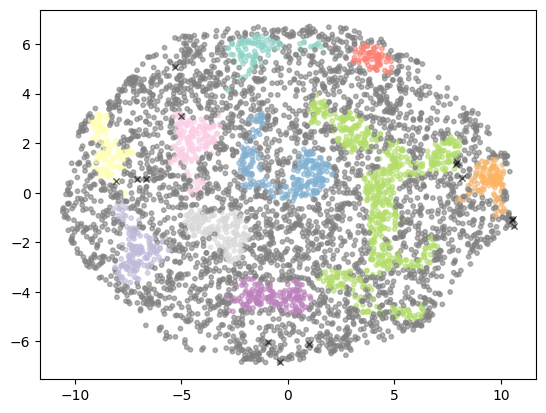

In [ ]:
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming hdbdata and scat are defined
# Cluster using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=45).fit(hdbdata)

# Define color palette
color_palette = sns.color_palette('Set3', 50)

# Assign colors to clusters
cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in clusterer.labels_]

# Desaturate colors based on probabilities
cluster_member_colors = [sns.desaturate(x, p) for x, p in zip(cluster_colors, clusterer.probabilities_)]

# Scatter plot for HDBSCAN clusters
plt.scatter(*hdbdata.T, s=10, linewidth=1, c=cluster_member_colors, alpha=0.6)

# Scatter plot for scat
plt.scatter(scat['dim1'], scat['dim2'], s=20, linewidth=1, edgecolors="black", marker='x', c="black", alpha=0.6)

# Show the plot
plt.show()


In [ ]:
pip install dadapy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from dadapy import Data
from dadapy.plot import plot_SLAn, plot_MDS, plot_matrix, get_dendrogram, plot_DecGraph

%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

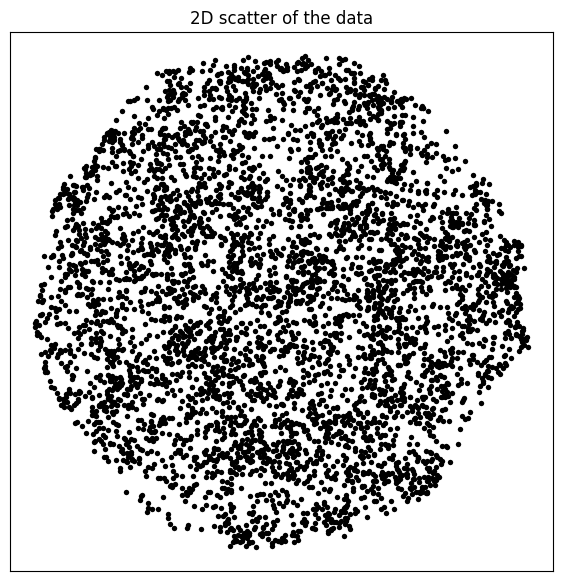

In [ ]:
f, ax = plt.subplots(1, 1, figsize = (7, 7),gridspec_kw={'hspace': 0.05, 'wspace': 0})
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('2D scatter of the data')
ax.scatter(hdbdata[:,0],hdbdata[:,1],s=15.,alpha=1.0,c='black',linewidths=0.0)
plt.show()

In [ ]:
data = Data(hdbdata,verbose=True)
data.compute_distances(maxk = 1000)
data.compute_id_2NN()
data.compute_density_PAk()
data.compute_density_kstarNN()

Computation of distances started
Computation of the distances up to 1000 NNs started
0.98 seconds for computing distances
ID estimation finished: selecting ID of [2.07]
kstar estimation started, Dthr = 23.92812698
0.44 seconds computing kstar
PAk density estimation started
6.77 seconds optimizing the likelihood for all the points
PAk density estimation finished
kstar estimation started, Dthr = 23.92812698
0.52 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished


(array([-5.4 , -5.54, -5.38, ..., -5.54, -5.56, -5.5 ]),
 array([0.03, 0.04, 0.09, ..., 0.05, 0.05, 0.07]))

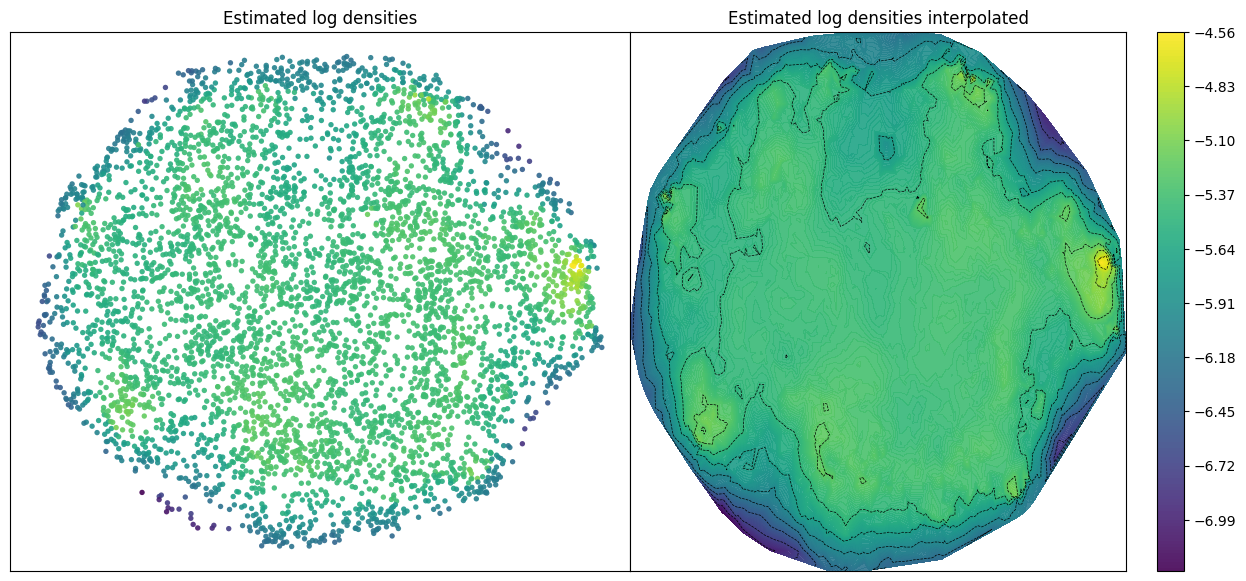

In [ ]:
f, [ax1 ,ax2] = plt.subplots(1, 2, figsize = (16, 7),gridspec_kw={'hspace': 0.05, 'wspace': 0})
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.set_title('Estimated log densities')

ax1.scatter(hdbdata[:,0],hdbdata[:,1],s=15.,alpha=0.9, c = data.log_den,linewidths=0.0)
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.set_title('Estimated log densities interpolated')
ax2.tricontour(hdbdata[:,0],hdbdata[:,1],data.log_den,levels=10, linewidths=0.5, colors='k')

fig2=ax2.tricontourf(hdbdata[:,0],hdbdata[:,1],data.log_den,levels=250,alpha=0.9)

plt.colorbar(fig2)
plt.show()

Number of points for which self.delta needed call to cdist= 6


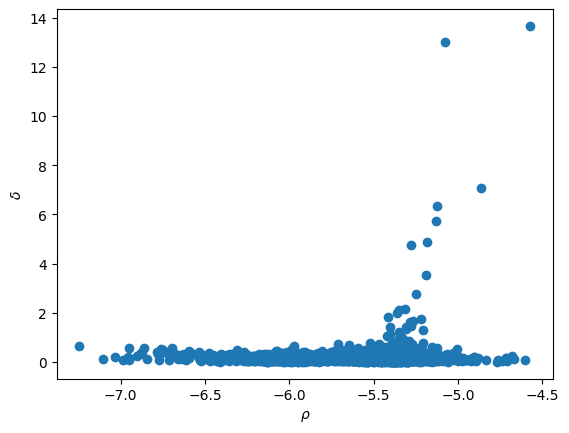

In [ ]:
plot_DecGraph(data)

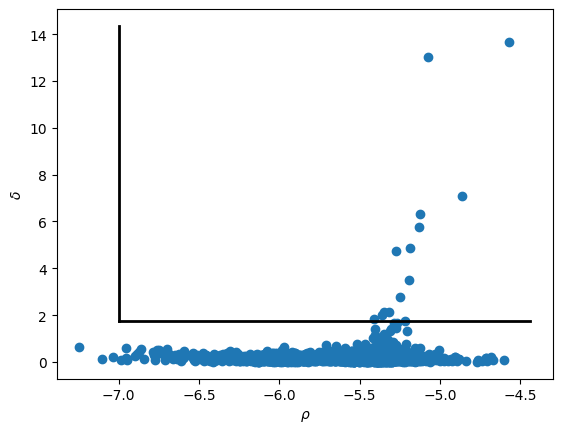

In [ ]:
# This graph shows the chosen outliers
dens_cut=-7.
delta_cut=1.75
plt.xlabel(r"$\rho$")
plt.ylabel(r"$\delta$")
plt.scatter(data.log_den, data.delta)
bottom,up=plt.ylim()
left,right=plt.xlim()
plt.plot ([dens_cut, dens_cut], [delta_cut, up], color="k", linestyle="-", linewidth=2)
plt.plot ([dens_cut, right], [delta_cut, delta_cut], color="k", linestyle="-", linewidth=2)
plt.show()

In [ ]:
data.compute_clustering_DP(dens_cut=dens_cut,delta_cut=delta_cut, halo=True)


array([-1, -1, -1, ..., -1, -1, -1])

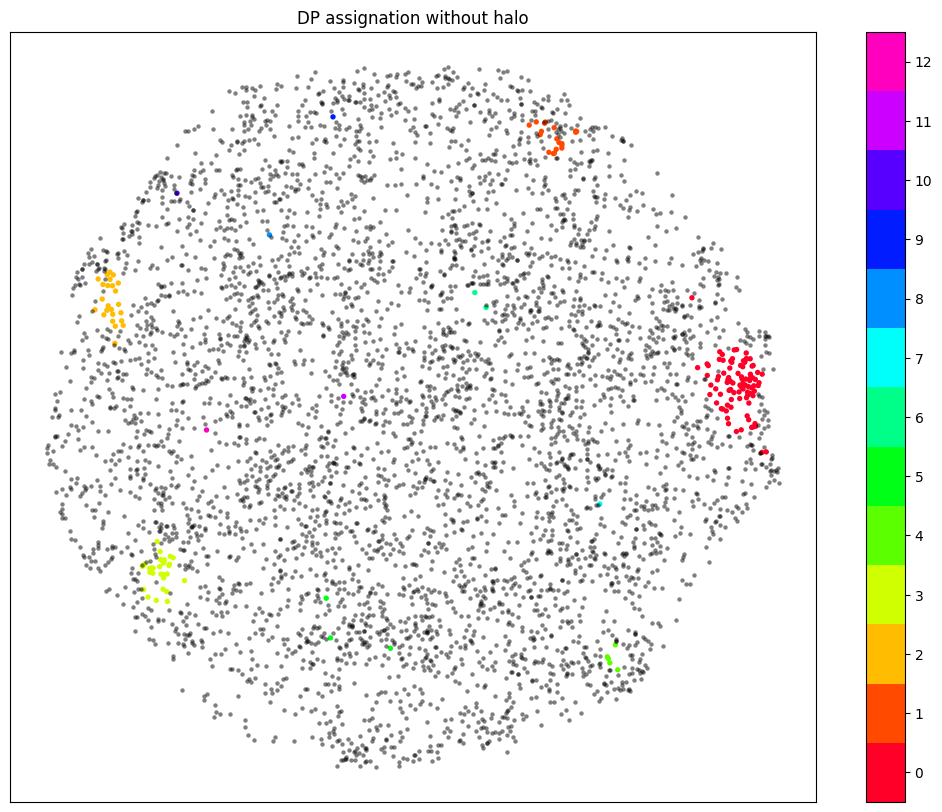

In [ ]:
Nclus_m=np.max(data.cluster_assignment)+1
color= plt.get_cmap('gist_rainbow', Nclus_m)
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('DP assignation without halo')
xdtmp=[]
ydtmp=[]
ldtmp=[]
xntmp=[]
yntmp=[]
for j in range(len(data.cluster_assignment)):
    if (data.cluster_assignment[j]!=-1):
        xdtmp.append(data.X[j,0])
        ydtmp.append(data.X[j,1])
        ldtmp.append(data.cluster_assignment[j])
    else:
        xntmp.append(data.X[j,0])
        yntmp.append(data.X[j,1])

plt.scatter(xdtmp,ydtmp,s=15.,alpha=1.0, c=ldtmp,linewidths=0.0,cmap=color)
plt.colorbar(ticks=range(Nclus_m))
plt.clim(-0.5, Nclus_m-0.5)
plt.scatter(xntmp,yntmp,s=10.,alpha=0.5, c='black',linewidths=0.0)
plt.show()

In [ ]:
data.compute_clustering_ADP(Z = 1.65, halo=True)

Clustering started
init succeded
Raw identification of the putative centers:  0.001 sec
Further checking on centers:  0.150 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.045 sec
('Number of clusters before multimodality test=', 13)
Identification of the saddle points:  0.061 sec
Multimodality test finished:  0.000 sec
Final operations: 0.0015459060668945312 sec
Clustering finished, 5 clusters found
total time is, 0.3369479179382324


array([-1, -1, -1, ..., -1, -1,  3])

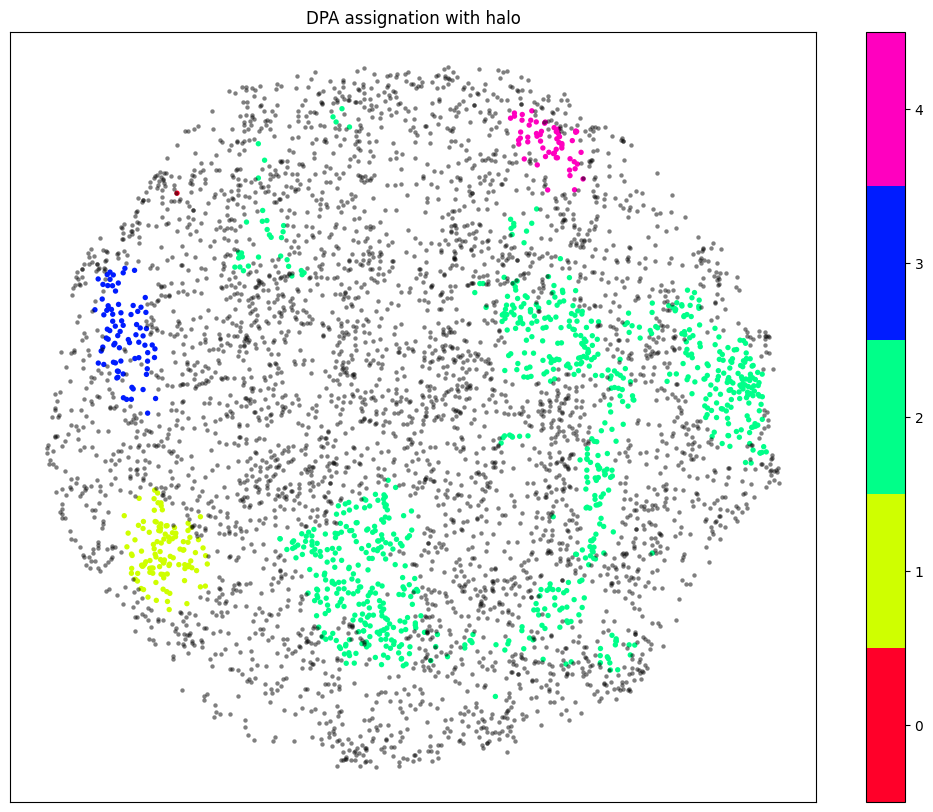

In [ ]:
Nclus_m=len(data.cluster_centers)
cmap = plt.get_cmap('gist_rainbow', Nclus_m)
f, ax = plt.subplots(1, 1, figsize = (13, 10))
ax.yaxis.set_major_locator(plt.NullLocator())
ax.xaxis.set_major_locator(plt.NullLocator())
ax.set_title('DPA assignation with halo')
xdtmp=[]
ydtmp=[]
ldtmp=[]
xntmp=[]
yntmp=[]
for j in range(len(data.cluster_assignment)):
    if (data.cluster_assignment[j]!=-1):
        xdtmp.append(data.X[j,0])
        ydtmp.append(data.X[j,1])
        ldtmp.append(data.cluster_assignment[j])
    else:
        xntmp.append(data.X[j,0])
        yntmp.append(data.X[j,1])

plt.scatter(xdtmp,ydtmp,s=15.,alpha=1.0, c=ldtmp,linewidths=0.0,cmap=cmap)
plt.colorbar(ticks=range(Nclus_m))
plt.clim(-0.5, Nclus_m-0.5)
plt.scatter(xntmp,yntmp,s=10.,alpha=0.5, c='black',linewidths=0.0)
plt.show()

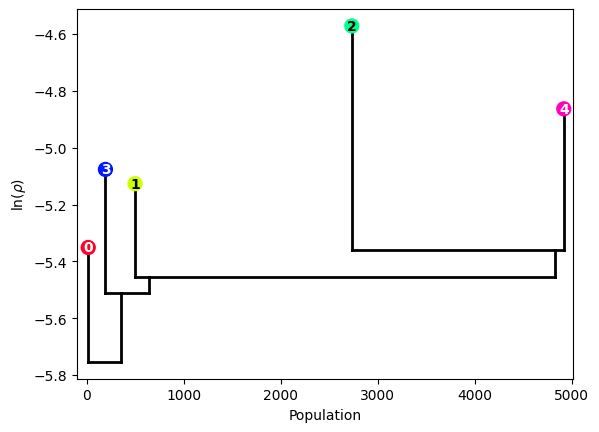

In [ ]:
get_dendrogram(data,logscale=False,cmap="gist_rainbow")

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



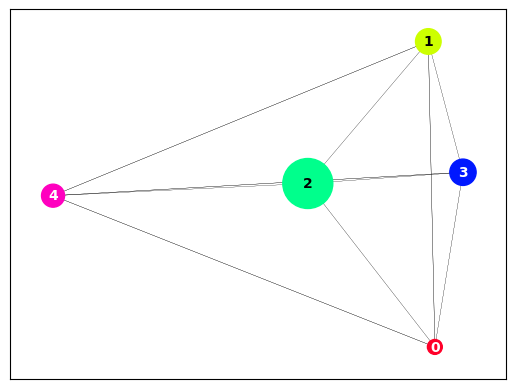

In [ ]:
plot_MDS(data,cmap='gist_rainbow')

In [ ]:
import plotly.express as px

# Assuming 'emb' is your DataFrame
fig = px.density_contour(emb, x="dim1", y="dim2", color="legend", color_discrete_sequence=px.colors.qualitative.Set1)

fig.update_layout(
    height=800,
    width=800,
    showlegend=False
)

fig.show()

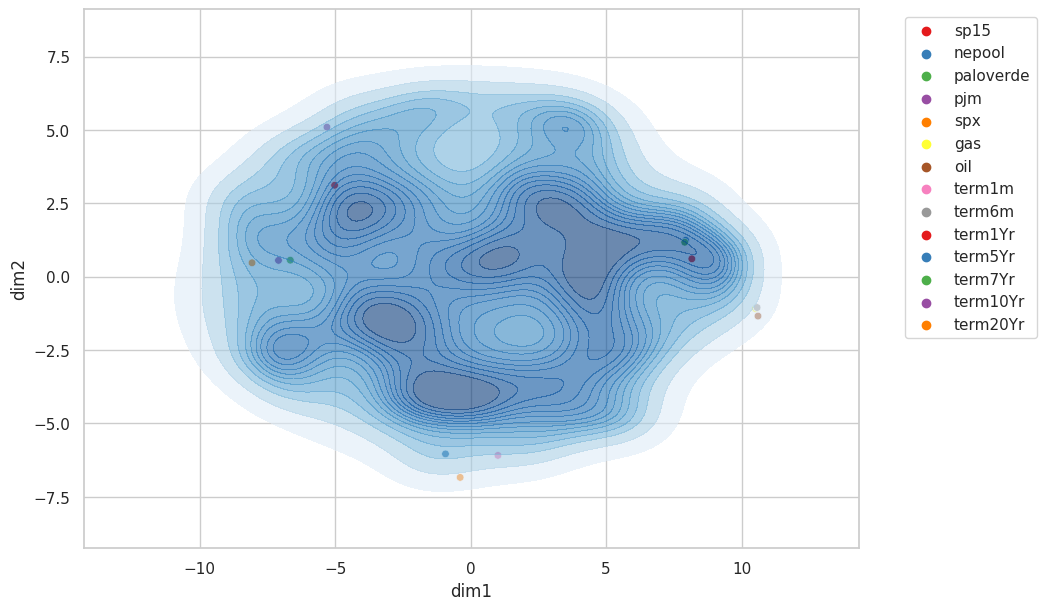

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'scat' and 'emb' are your DataFrames
plt.figure(figsize=(10, 7))

# Create a scatter plot with all points in white
sns.scatterplot(x='dim1', y='dim2', hue='legend', data=scat, palette='Set1', s=30, alpha=1)

# Create a 2D kernel density estimate plot
sns.kdeplot(data=emb, x='dim1', y='dim2', fill=True, cmap='Blues', levels=15, alpha=0.6)

# Set plot title and labels

# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()


In [ ]:
scat=emb[emb['legend']!="barycenter"]

In [ ]:
import seborn as

<ipython-input-63-0dbf5581a724>:2: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.



<Axes: xlabel='dim1', ylabel='dim2'>

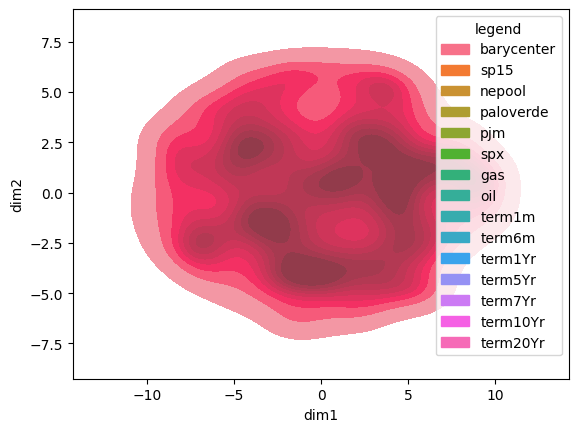

In [ ]:
# Plotting the KDE Plot
sns.kdeplot(
    data=emb, x="dim1", y="dim2", hue="legend", fill=True,
)

In [ ]:
emb

,dim1,dim2,legend
0,-1.904984,-1.044145,barycenter
1,-1.035561,2.542962,barycenter
2,-4.340372,4.737502,barycenter
3,-0.139467,-3.955014,barycenter
4,-9.074159,0.974263,barycenter
...,...,...,...
5009,-5.019649,3.114552,term1Yr
5010,-0.927922,-6.036373,term5Yr
5011,-6.654065,0.561884,term7Yr
5012,-7.090418,0.555967,term10Yr


In [ ]:
plotly.offline.plot(fig, filename='lifeExp.html')

'lifeExp.html'